# Train Front RGB image to BEV on simulation dataset

## Library

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [2]:
def apply_roi_mask(image, roi_angle=90, center=None):
    """
    image: Tensor [C, H, W] or [H, W, C]
    roi_angle: in degrees, field of view (e.g. 90° in front)
    center: center point (x, y); default is image center
    """
    if image.dim() == 3 and image.shape[0] < image.shape[1]:  # [C, H, W] -> [H, W]
        h, w = image.shape[1:]
    else:
        h, w = image.shape[:2]

    if center is None:
        center = (w // 2, h//2)

    yy, xx = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    dx = xx - center[0]
    dy = center[1] - yy

    angles = torch.atan2(dy, dx) * 180 / torch.pi
    mask = (angles >= -roi_angle/2 + 90) & (angles <= roi_angle/2 + 90)

    return mask.float()  # [H, W]

class RGBToBEVDataset(Dataset):
    def __init__(self, front_dir, bev_dir):
        fronts = sorted([f for f in os.listdir(front_dir) if f.endswith(".png")])
        bevs = sorted([f for f in os.listdir(bev_dir) if f.endswith(".png")])
        self.pairs = [(os.path.join(front_dir, f), os.path.join(bev_dir, f))
                      for f in fronts if f in bevs]  # Only matching filenames

        assert len(self.pairs) > 0, "No matching image pairs found."

        self.front_transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        self.bev_transform = transforms.Compose([
            transforms.Resize((384, 384), interpolation=Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        front_path, bev_path = self.pairs[idx]
        front = Image.open(front_path).convert("RGB")
        bev = Image.open(bev_path)
        front_tensor = self.front_transform(front)
        bev_tensor = self.bev_transform(bev).float()
        roi_mask = apply_roi_mask(bev_tensor, roi_angle=90).to(bev_tensor.device)
        bev_tensor = bev_tensor * roi_mask.unsqueeze(0)
        return front_tensor, bev_tensor



In [3]:
front_dir = "../data/images_aligned/front"
bev_dir = "../data/images_aligned/bev"

dataset = RGBToBEVDataset(front_dir, bev_dir)
front, bev = dataset[0]
print(front.shape)  # [3, 384, 512]
print(bev.shape)    # [512, 512]
print(bev.dtype)    # torch.int64

torch.Size([3, 384, 384])
torch.Size([3, 384, 384])
torch.float32


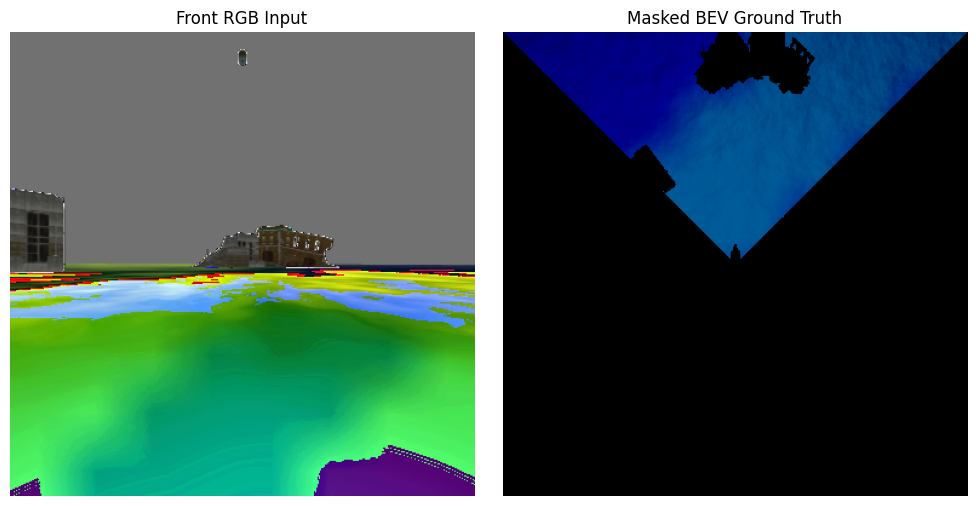

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Assume dataset is already defined and includes mask application
sample_idx = 0
rgb, masked_bev = dataset[sample_idx]  # [3, H, W] each

# Convert tensors to [H, W, 3] for matplotlib
rgb_np = TF.to_pil_image(rgb).convert("RGB")
bev_np = TF.to_pil_image(masked_bev.clamp(0, 1)).convert("RGB")

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_np)
plt.title("Front RGB Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bev_np)
plt.title("Masked BEV Ground Truth")
plt.axis("off")

plt.tight_layout()
plt.show()


## model

In [5]:
class FrontToBEVUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # [B, 32, 192, 256]
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),            # [B, 64, 96, 128]
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)            # [B, 128, 48, 64]
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),       # [B, 128, 96, 128]
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),        # [B, 64, 192, 256]
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),         # [B, 32, 384, 512]
            nn.Conv2d(32, out_channels, 1),                                        # [B, C, 384, 512]
        )
        self.output_resizer = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return self.output_resizer(x)  # Final [B, C, 512, 512]

class ViTUNet(nn.Module):
    def __init__(self, image_size=(384, 384), out_channels=3, backbone='vit_base_patch16_384'):
        super().__init__()
        self.image_size = image_size
        self.out_channels = out_channels

        # Vision Transformer encoder
        self.encoder = timm.create_model(backbone, pretrained=True, features_only=True)
        encoder_channels = self.encoder.feature_info[-1]['num_chs']

        # Decoder with smoother upsampling
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(encoder_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # normalize RGB to [0,1]
        )

    def forward(self, x):  # x: [B, 3, H, W]
        feats = self.encoder(x)[-1]  # [B, C, H/32, W/32]
        out = self.decoder(feats)    # [B, 3, H, W]
        out = F.interpolate(out, size=self.image_size, mode='bilinear', align_corners=False)
        return out        # [B, 3, 384, 384]

## Training

In [9]:
bev = Image.open("../data/images/bev/409490000000.png")
bev_tensor = dataset.bev_transform(bev).float()
roi_mask = apply_roi_mask(bev_tensor, roi_angle=90).to(bev_tensor.device)

roi_mask = F.interpolate(roi_mask.unsqueeze(0).unsqueeze(0), size=(384, 384), mode='nearest')
roi_mask = (roi_mask > 0.5).float().to("cuda")  # Already binary, just ensure device

def train_rgb_to_bev(front_dir, bev_dir, batch_size=8, epochs=20, device='cuda'):
    dataset = RGBToBEVDataset(front_dir, bev_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # model = FrontToBEVUNet(in_channels=3, out_channels=num_classes).to(device)
    model = ViTUNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # criterion = F.mse_loss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for rgb, bev in dataloader:
            rgb, bev = rgb.to(device), bev.to(device)
            pred = model(rgb)
            loss_mask = roi_mask.expand_as(pred)
            masked_pred = pred * loss_mask
            masked_bev = bev * loss_mask
            loss = F.mse_loss(masked_pred, masked_bev, reduction='sum')
            loss = loss / loss_mask.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader):.4f}")

    return model


In [ ]:
model = train_rgb_to_bev(
    front_dir="../data/images_aligned/front",
    bev_dir="../data/images_aligned/bev",
    epochs=20,
    batch_size=4
)

Epoch 1/20 - Loss: 0.2192
Epoch 2/20 - Loss: 0.2132


In [8]:
save_path = "../RGB2BEV/vitunet_rgb2bev.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to ../RGB2BEV/vitunet_rgb2bev.pth


## Inference

In [ ]:
model = ViTUNet()
model.load_state_dict(torch.load("../RGB2BEV/vitunet_rgb2bev.pth"))
model.eval()
model.to("cuda")

In [9]:
def infer_and_save_bev(model, image_path, output_path, device='cuda'):
    model.eval()
    model.to(device)

    # Preprocess input image
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ])
    
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 384, 512]

    with torch.no_grad():
        output = model(input_tensor)[0]  # [3, 384, 384]

    # Convert to image and save
    output_image = output.clamp(0, 1).cpu().permute(1, 2, 0).numpy()  # [384, 384, 3]

    # Save or display
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.imsave(output_path, output_image)
    print(f"Inference saved to {output_path}")

In [11]:
infer_and_save_bev(
    model,
    image_path="../data/images/front/409491000000.png",
    output_path="./output/bev_predicted.png"
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/images/front/409491000000.png'